In [1]:
import vespa
import h5py
import numpy as np
import pandas as pd
import sqlite3
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import constants 

from scipy.stats import gaussian_kde
import emcee
import corner

from matplotlib import pyplot as plt
%matplotlib notebook

import sys
sys.path.insert(0, '/Users/ageller/WORK/LSST/onGitHub/EBLSST/code')
from EBLSST import BreivikGalaxy, EclipsingBinary

%load_ext autoreload
%autoreload 2

/Users/ageller/anaconda/envs/py36/lib/python3.6/site-packages/numpy/lib/npyio.py:2222: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)
/Users/ageller/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/ageller/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module

### Get the field centers and number of observations from OpSim

In [ ]:
#https://www.lsst.org/scientists/simulations/opsim/summary-table-column-descriptions-v335
#http://ops2.lsst.org/docs/current/architecture.html
db = sqlite3.connect('/Users/ageller/WORK/LSST/onGitHub/EBLSST/db/minion_1016_sqlite.db')
cursor = db.cursor()
cursor.execute("SELECT fieldid, fieldra, fielddec, fieldFov FROM field")
#cursor.execute("SELECT fielddec FROM field")
fieldCursor = np.array(cursor.fetchall()) 

cursor.execute("SELECT fieldid, expDate, filter FROM summary")
summaryCursor = np.array(cursor.fetchall()) 
FieldID = summaryCursor[:,0].astype('int')
date = summaryCursor[:,1].astype('float')

fID = np.array([])
RA = np.array([])
Dec = np.array([])
nobs = np.array([])
for x in fieldCursor:
    inS = np.where(FieldID == int(x[0]))[0]
    nobs = np.append(nobs, len(inS))
    fID = np.append(fID, x[0])
    RA = np.append(RA, x[1])
    Dec = np.append(Dec, x[2])
    
    print(x[0], x[1], x[2],len(inS))


In [ ]:
coords = SkyCoord(RA, Dec, unit=(u.degree, u.degree),frame='icrs')
lGal = coords.galactic.l.wrap_at(180.*u.degree).degree
bGal = coords.galactic.b.wrap_at(180.*u.degree).degree

raGal = coords.icrs.ra.wrap_at(180.*u.degree).degree
decGal = coords.icrs.dec.wrap_at(180.*u.degree).degree

f,ax = plt.subplots()
ax.hist(nobs,bins = 100, range=(0,5000))
ax.set_yscale('log', nonposy='clip')

f, ax = plt.subplots(subplot_kw={'projection': "mollweide"})
ax.grid(True)
ax.set_xlabel(r"$RA$",fontsize=16)
ax.set_ylabel(r"$Dec$",fontsize=16)
xx = np.where(nobs > 0)
ax.scatter(raGal[xx]*np.pi/180.,decGal[xx]*np.pi/180., s = 0.5, c=nobs[xx], cmap='tab10', alpha = 1, vmin=0, vmax=1000)

f, ax = plt.subplots(subplot_kw={'projection': "mollweide"})
ax.grid(True)
ax.set_xlabel(r"$l$",fontsize=16)
ax.set_ylabel(r"$b$",fontsize=16)
ax.scatter(lGal[xx]*np.pi/180.,bGal[xx]*np.pi/180., s = 0.5, c=nobs[xx], cmap='tab10', alpha = 1, vmin=0, vmax=1000)


### Get the TRILEGAL simulation at each OpSim field

*Just look at the first one for a test*

In [ ]:
#this area is a bit odd because we're on a sphere... 
area = 10.
maglim = 24
sigma_AV = 0.1 #default
binaries = False
filterset = 'lsst' #kepler_2mass

for r,d,f in zip(RA,Dec,fID):
    print(r,d,f)
    filename = 'grid/trilegal.grid.id'+str(f)
    x = vespa.stars.trilegal.get_trilegal(filename, r, d, galactic=False, \
                                  filterset=filterset, area=area, maglim=maglim, binaries=binaries, \
                                  trilegal_version='1.6', sigma_AV=sigma_AV, convert_h5=True)
    
    break

In [ ]:
print(x)

## Read in the TRILEGAL model to test

In [2]:
filename = 'grid/trilegal.grid.id1.0.h5'
df = pd.read_hdf(filename)
#dist = 10.**(df['m-M0'].values/5.) * 10.# *u.parsec
dist = np.log10( 10.**(df['m-M0'].values/5.) *10. / 1000.) #log(d [kpc])
df['dist'] = dist

print(df)

data = np.vstack((df['logL'].values, df['logTe'].values, df['logg'].values))
TRILEGAL_KDE = gaussian_kde(data)


        Gc  logAge  [M/H]     m_ini   logL  logTe   logg  m-M0     Av  m2/m1  \
0        1    6.65   0.27   0.51311 -1.374  3.592  4.837   7.2  0.347    0.0   
1        1    6.71  -0.19   0.13318 -1.740  3.509  4.285   8.0  0.458    0.0   
2        1    6.71  -0.09   0.74550 -0.736  3.671  4.676   8.2  0.371    0.0   
3        1    6.87  -0.07   1.62066  0.870  3.896  4.307   9.7  0.568    0.0   
4        1    6.87   0.07   0.74828 -0.767  3.661  4.668   8.8  0.431    0.0   
5        1    6.87   0.27   1.31862  0.403  3.806  4.326  12.8  0.432    0.0   
6        1    7.07   0.23   0.11043 -1.914  3.482  4.269   4.4  0.112    0.0   
7        1    7.15  -0.17   0.78918 -0.596  3.693  4.650   7.6  0.372    0.0   
8        1    7.15  -0.09   0.80570 -0.582  3.693  4.642  10.3  0.457    0.0   
9        1    7.17   0.13  14.01946  4.484  4.395  3.626   9.3  0.483    0.0   
10       1    7.21   0.17   0.22026 -2.181  3.536  5.052   7.1  0.346    0.0   
11       1    7.25   0.01   0.35666 -1.7

*Check some plots*

103604


Text(0.5,0,'logg')

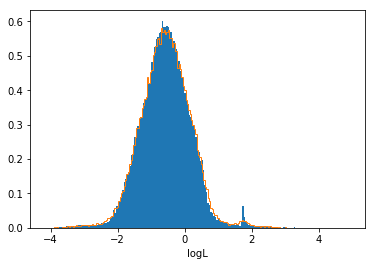

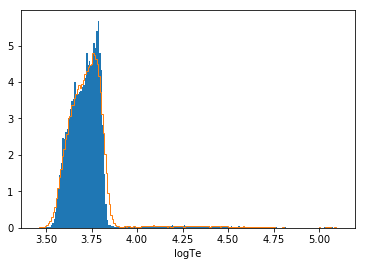

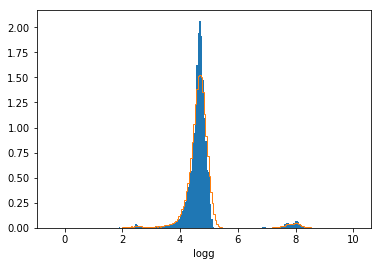

In [3]:
print(len(dist))
nbins = 200

sample = TRILEGAL_KDE.resample(size=int(1e5))
    
# f,ax = plt.subplots()
# n, bins, patches = ax.hist(df['dist'].values, bins=nbins, density=True)
# ax.set_xlabel('distance (pc)')

# f,ax = plt.subplots()
# n, bins, patches = ax.hist(df['Av'].values, bins=nbins, density=True)
# ax.set_xlabel('Av')

f,ax = plt.subplots()
n, bins, patches = ax.hist(df['logL'].values, bins=nbins, density=True)
n, bins, patches = ax.hist(sample[0,:], bins=nbins, density=True, histtype='step')
ax.set_xlabel('logL')

f,ax = plt.subplots()
n, bins, patches = ax.hist(df['logTe'].values, bins=nbins, density=True)
n, bins, patches = ax.hist(sample[1,:], bins=nbins, density=True, histtype='step')
ax.set_xlabel('logTe')

f,ax = plt.subplots()
n, bins, patches = ax.hist(df['logg'].values, bins=nbins, density=True)
n, bins, patches = ax.hist(sample[2,:], bins=nbins, density=True, histtype='step')
ax.set_xlabel('logg')



### Now draw some binaries from Katie Breivik's model

In [4]:
g = BreivikGalaxy()

#define the correct paths to the input files and db
g.GalaxyFile ='/Users/ageller/WORK/LSST/onGitHub/EBLSST/input/dat_ThinDisk_12_0_12_0.h5' #for Katie's model
g.GalaxyFileLogPrefix ='/Users/ageller/WORK/LSST/onGitHub/EBLSST/input/fixedPopLogCm_'

g.getKernel()

The number of binaries in the Gx for: 0012 is: 22919080853
both bright stars and eccentric


*This is how to draw stars from Katie's model*

In [5]:
nSample = 1
BreivikBin = g.GxSample(nSample)
EB = EclipsingBinary()
BreivikBin['Teff1'] = EB.getTeff(BreivikBin['Lum1'].values[0], BreivikBin['rad1'].values[0])
BreivikBin['Teff2'] = EB.getTeff(BreivikBin['Lum2'].values[0], BreivikBin['rad2'].values[0])
print(BreivikBin)


         m1        m2      logp       ecc      rad1      rad2      Lum1  \
0  0.336668  0.106293  3.696198  0.955225  1.115133  0.377329  0.373368   

       Lum2        xGX         yGX         zGX  dist_kpc       inc     OMEGA  \
0  0.005504  28.753088 -107.202544 -165.409177  7.974241  1.610032  0.868188   

      omega        Teff1        Teff2  
0  4.740737  4279.282166  2563.362285  


### Use emcee to sample Breivik's model using the logL and logT distributions from TRILEGAL

*For our LSST model, I need the following from Katie:*

**m1, m2, r1, r2, ecc, porb**

*I also need to following, but these are random anyway:*

**omega, inc**

inc = np.arccos(2.*np.random.uniform(0,1.0,len(m1)) - 1.)

omega = np.random.uniform(0,2*math.pi,len(m1))

In [38]:
# compute the log likelihood
def lnlike(theta):
    _,_,_, logm2, logr2, logL2, ecc, logp = theta
    
    #get the primary star from the TRILEGAL model
    sample = TRILEGAL_KDE.resample(size=1)
    logL1 = sample[0,0]
    logT1 = sample[1,0]
    logg1 = sample[2,0]
    
    logr1 = 2.*(0.25*logL1 - logT1 + 3.762) #taken from my N-body notes to get logT <-- from Jarrod Hurley
    
    #np.log10(constants.G.to(u.cm**3. / u.g / u.s**2.).value) = -7.175608591905032
    #print(np.log10((1.*u.solMass).to(u.g).value)) = 33.29852022592346
    logm1 = logg1 + 7.175608591905032 + 2.*(logr1 + 10.84242200335765) - 33.29852022592346
   
    ln_l = g.sampleKernel((10.**logm1, 10.**logm2, logp, ecc, 10.**logr1, 10.**logr2, 10.**logL1, 10.**logL2))
    
    return ln_l.squeeze()

# compute the log prior
def lnprior(theta):
    #some reasonable limits to place, so that Breivik's KDE can be sampled properly
    _,_,_, logm2, logr2, logL2, ecc, logp = theta
    if ( (-1 < logm2 < 1) and (-2 < logr2 < 2) and (-5 < logL2 < 5) and (0 < ecc < 1) and (-3 < logp < 10)):
        return 0.0
    return -np.inf

# compute the log of the likelihood multiplied by the prior
def lnprob(theta):
    lnp = lnprior(theta)
    lnl = lnlike(theta)
    if (not np.isfinite(lnp) or not np.isfinite(lnl)):
        return -np.inf
    return lnp + lnl

In [39]:
#some function to make plots (will re-use them later)
#to plot the chains
def plotChains(sampler, nburn, paramsNames):
    Nparams = len(paramsNames)
    fig, ax = plt.subplots(Nparams,1, figsize = (8,2*Nparams), sharex = True)
    fig.subplots_adjust(hspace = 0)
    ax[0].set_title('Chains')
    xplot = range(len(sampler.chain[0,:,0]))

    for i,p in enumerate(paramsNames):
        for w in range(sampler.chain.shape[0]):
            ax[i].plot(xplot[:nburn], sampler.chain[w,:nburn,i], color="0.5", alpha = 0.4, lw = 0.7, zorder = 1)
            ax[i].plot(xplot[nburn:], sampler.chain[w,nburn:,i], color="k", alpha = 0.4, lw = 0.7, zorder = 1)
            
            ax[i].set_ylabel(p)
            
    return ax

#corner plot
def makeCorner(sampler, nburn, paramsNames, quantiles=[0.16, 0.5, 0.84]):
    samples = sampler.chain[:, nburn:, :].reshape((-1, len(paramsNames)))
    f = corner.corner(samples, labels = paramsNames, quantiles = quantiles)



In [40]:
nwalkers = 100
ncores = 4
ndim = 8
nsamples = 2000

paramsNames = ['m1', 'rad1', 'Lum1', 'm2', 'rad2', 'Lum2', 'ecc', 'logp']
outNames = ['logm1', 'logr1', 'logL1', 'logm2', 'logr2', 'logL2', 'ecc', 'logp']
reNames = {}
for x,y in zip(paramsNames, outNames):
    reNames[x] = y

BreivikBin = g.GxSample(int(nwalkers))

walkers = pd.concat( [ BreivikBin[paramsNames[:-2]].apply(np.log10), BreivikBin[paramsNames[-2:]] ], axis=1)
walkers.rename(columns = reNames, inplace=True)

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, threads = ncores)

foo = sampler.run_mcmc(walkers.values, nsamples)

/Users/ageller/anaconda/envs/py36/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/ageller/anaconda/envs/py36/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


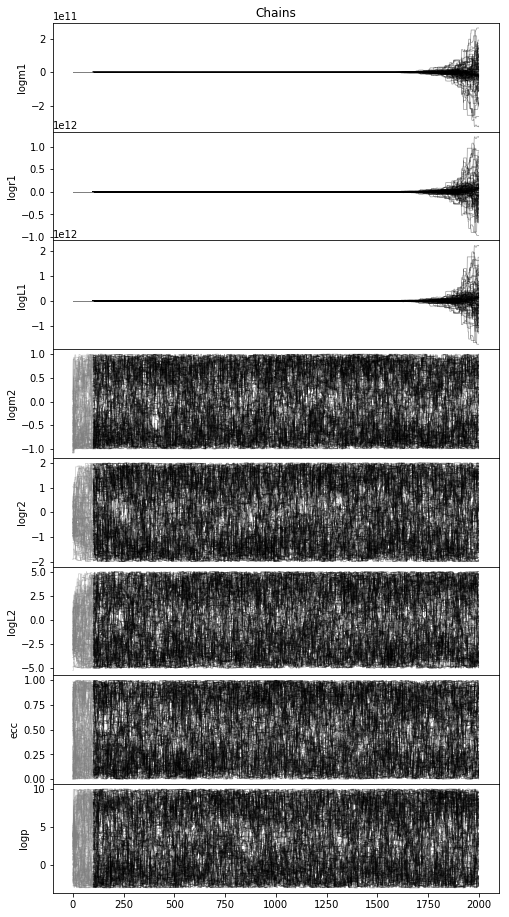

In [41]:
nburn = 100
#paramsNames = ['m2', 'rad2', 'Lum2', 'ecc', 'porb']
axC = plotChains(sampler, nburn, outNames)

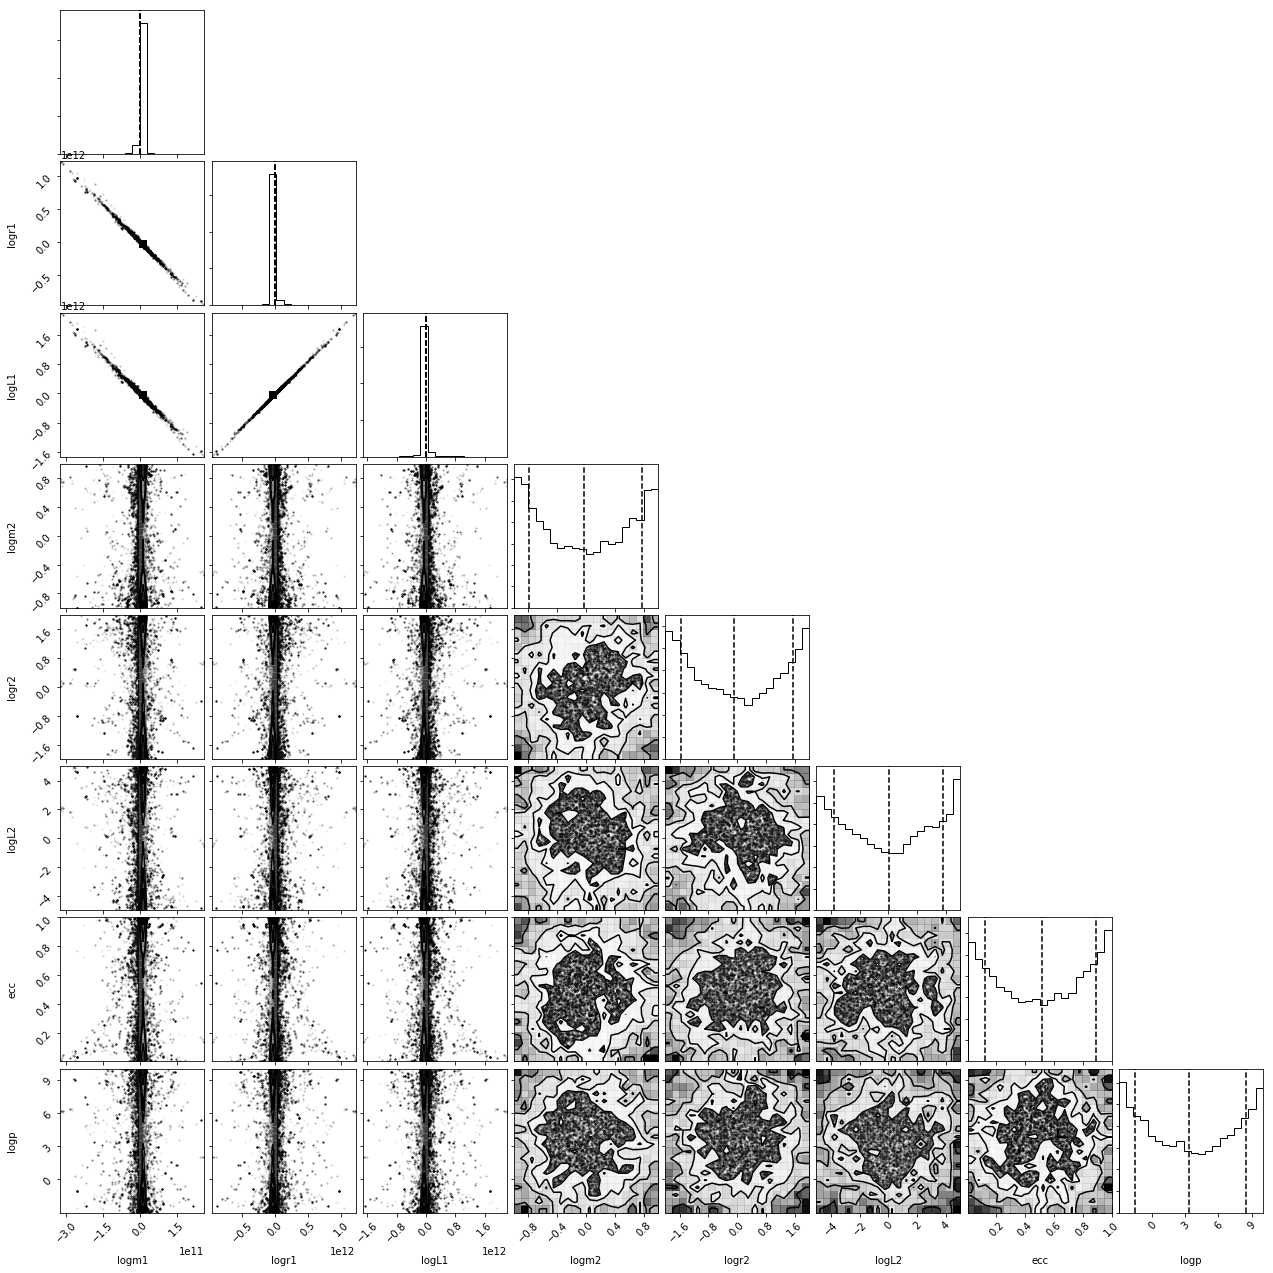

In [42]:
makeCorner(sampler, nburn, outNames)

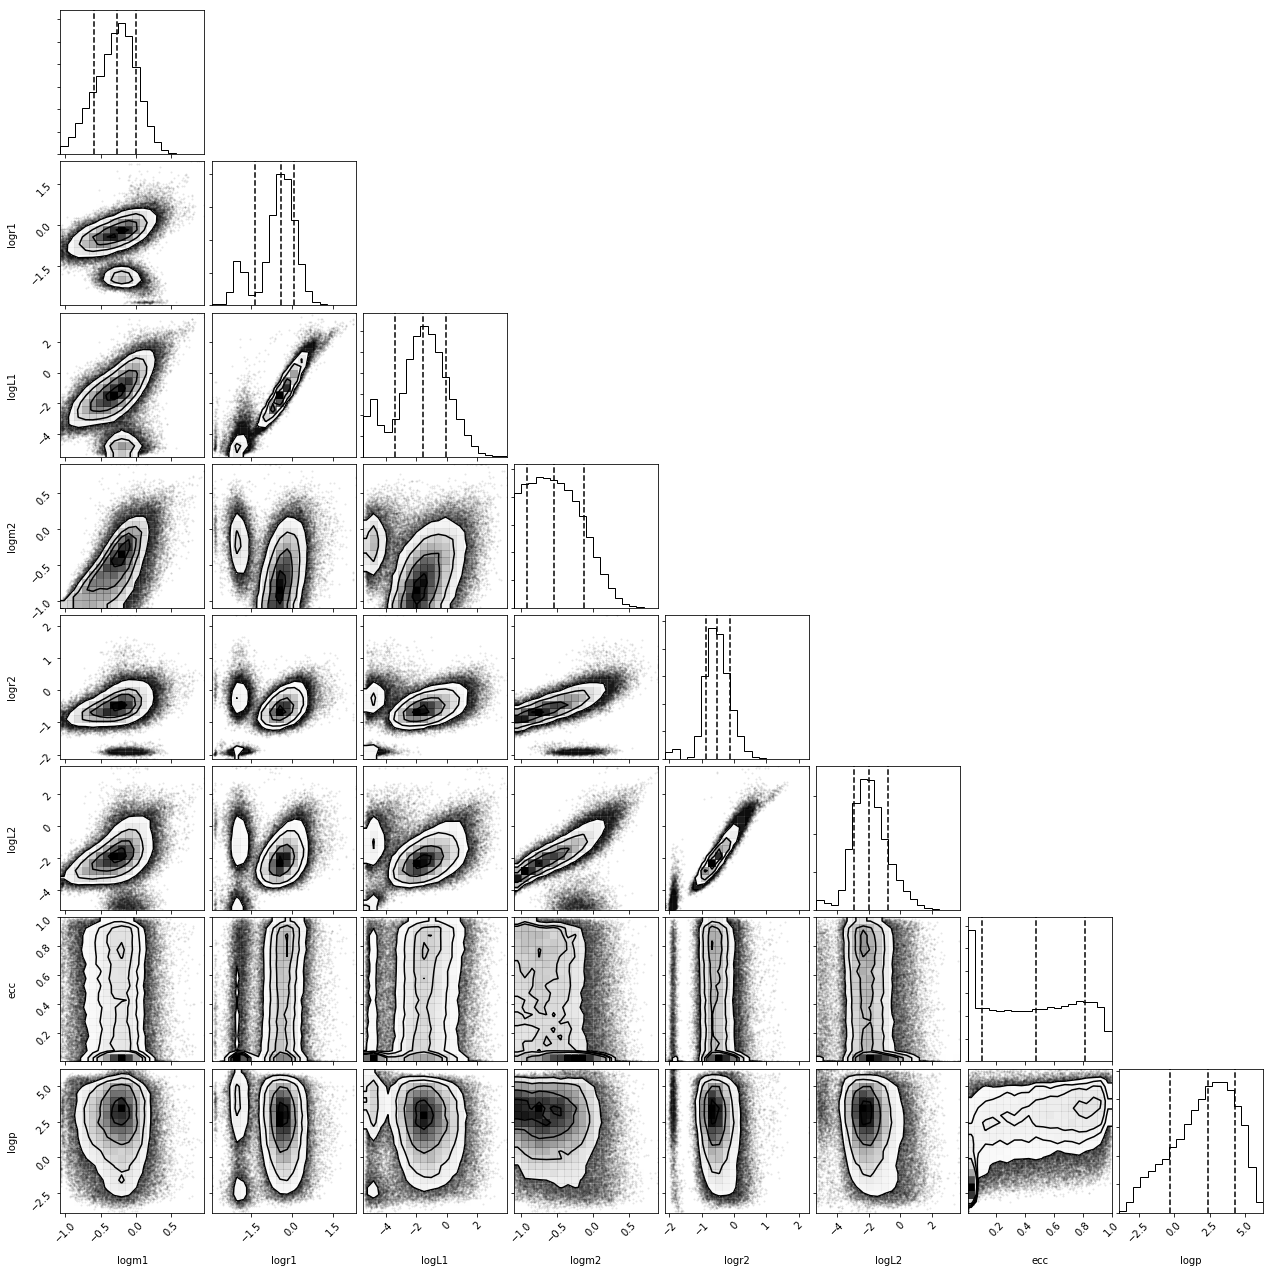

In [33]:
#compare to Breivik's model
paramsNames = ['m1', 'rad1', 'Lum1', 'm2', 'rad2', 'Lum2', 'ecc', 'logp']
outNames = ['logm1', 'logr1', 'logL1', 'logm2', 'logr2', 'logL2', 'ecc', 'logp']
reNames = {}
for x,y in zip(paramsNames, outNames):
    reNames[x] = y

BreivikBin = g.GxSample(int(1e5))

check = pd.concat( [ BreivikBin[paramsNames[:-2]].apply(np.log10), BreivikBin[paramsNames[-2:]] ], axis=1)
check.rename(columns = reNames, inplace=True)

#print(check)
      
f = corner.corner(check.values, labels = outNames, quantiles = [0.16, 0.5, 0.84])


### Some checks for the numbers used in the likelihood

In [ ]:
print(constants.G.to(u.cm**3. / u.g / u.s**2.))
print(np.log10(constants.G.to(u.cm**3. / u.g / u.s**2.).value))
print(np.log10((1.*u.solMass).to(u.g).value))
print(np.log10((1.*u.solRad).to(u.cm).value))
print( np.log10((constants.G*1*u.solMass/(1.*u.solRad)**2.).decompose().to(u.cm/u.s**2).value))

logm = 4.44 + 7.175608591905032 + 2.*(0. + 10.84242200335765) - 33.29852022592346
print("logm = ",logm)
print("mass = ",10**logm)